# Baseline Model Training v5 - Sunday Fix & CatBoost

Improvements over v4:
1. **Fixed Sunday encoding**: Ratio-based boost instead of sparse binary
2. **High-attendance indicators**: is_dec_holiday_game, is_top_opponent
3. **Removed useless features**: is_late_season, christmas_proximity, is_friday_evening
4. **CatBoost**: Native categorical encoding for opponents
5. **Better validation**: TimeSeriesSplit with all data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from xgboost import XGBRegressor
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib
import holidays
import warnings
warnings.filterwarnings('ignore')

## 1. Load Data

In [2]:
df = pd.read_csv('Data/data_v1/grizzlys_combined_schedule_sales_v3.csv')
df['datetime'] = pd.to_datetime(df['datetime'])
df['date'] = pd.to_datetime(df['date'])

print(f"Total samples: {len(df)}")
print(f"Seasons: {df['season'].unique()}")
print(f"Ticket count range: {df['ticket_count'].min():.0f} - {df['ticket_count'].max():.0f}")

Total samples: 77
Seasons: ['22-23' '23-24' '24-25']
Ticket count range: 252 - 3492


## 2. Feature Engineering (Improved)

In [3]:
data = df.copy()

# Basic time features
data['month'] = data['datetime'].dt.month
data['weekday'] = data['datetime'].dt.weekday
data['hour'] = data['datetime'].dt.hour + data['datetime'].dt.minute/60
data['day'] = data['datetime'].dt.day

# Cyclical weekday
data['weekday_sin'] = np.sin(2 * np.pi * data['weekday'] / 7)
data['weekday_cos'] = np.cos(2 * np.pi * data['weekday'] / 7)

print("Basic time features added")

Basic time features added


In [4]:
# IMPROVED: Sunday afternoon - continuous score instead of binary
# Sunday = weekday 6, afternoon = 14:00-17:00
def sunday_score(row):
    if row['weekday'] == 6:  # Sunday
        if 14 <= row['hour'] <= 17:
            return 2.0  # Sunday afternoon - highest
        else:
            return 1.0  # Sunday other time
    return 0.0

data['sunday_score'] = data.apply(sunday_score, axis=1)

print(f"Sunday score distribution:")
print(data['sunday_score'].value_counts().sort_index())

Sunday score distribution:
sunday_score
0.0    45
1.0     5
2.0    27
Name: count, dtype: int64


In [5]:
# Holiday features
german_holidays = holidays.Germany(state='NI', years=[2022, 2023, 2024, 2025])

# IMPROVED: December holiday period (Dec 20-31) - these are HIGH attendance
def is_dec_holiday_game(date):
    if date.month == 12 and date.day >= 20:
        return 1
    return 0

data['is_dec_holiday'] = data['date'].apply(is_dec_holiday_game)

# Combined holiday score (simplified)
def holiday_score(date):
    score = 0
    month, day = date.month, date.day
    
    # Public holiday
    if date in german_holidays:
        score += 2
    
    # Christmas/New Year period
    if (month == 12 and day >= 20) or (month == 1 and day <= 6):
        score += 2
    
    # School holidays (fall)
    if month == 10 and 4 <= day <= 19:
        score += 1
        
    return score

data['holiday_score'] = data['date'].apply(holiday_score)

print(f"December holiday games: {data['is_dec_holiday'].sum()}")
print(f"Holiday score distribution: {data['holiday_score'].value_counts().sort_index().to_dict()}")

December holiday games: 7
Holiday score distribution: {0: 59, 1: 8, 2: 8, 4: 2}


In [6]:
# Season features
data['spieltag'] = data['spieltag']

# Distance log
data['distance_log'] = np.log(data['distance'])

print("Season and distance features added")

Season and distance features added


In [7]:
# IMPROVED: Top opponent indicator
# Based on historical data: Berlin, Düsseldorf, Köln, Bremerhaven have highest attendance
top_opponents = ['Eisbären Berlin', 'Düsseldorfer EG', 'Kölner Haie', 'Pinguins Bremerhaven']
data['is_top_opponent'] = data['away_team'].isin(top_opponents).astype(int)

print(f"Top opponent games: {data['is_top_opponent'].sum()}")
print(f"\nAvg attendance by opponent type:")
print(data.groupby('is_top_opponent')['ticket_count'].mean())

Top opponent games: 23

Avg attendance by opponent type:
is_top_opponent
0    1512.351852
1    2219.608696
Name: ticket_count, dtype: float64


## 3. Split Data

In [8]:
# Split by season
train_data = data[data['season'].isin(['22-23', '23-24'])].copy()
test_data = data[data['season'] == '24-25'].copy()

print(f"Training: {len(train_data)} (22-23 & 23-24)")
print(f"Test: {len(test_data)} (24-25)")

Training: 52 (22-23 & 23-24)
Test: 25 (24-25)


In [9]:
# Opponent encoding from training data
opponent_median = train_data.groupby('away_team')['ticket_count'].median()
global_median = opponent_median.median()

train_data['opponent_attendance'] = train_data['away_team'].map(opponent_median)
test_data['opponent_attendance'] = test_data['away_team'].map(opponent_median)
test_data['opponent_attendance'].fillna(global_median, inplace=True)

print("Opponent median attendance:")
print(opponent_median.sort_values(ascending=False))

Opponent median attendance:
away_team
Eisbären Berlin            2412.0
Düsseldorfer EG            2375.0
Pinguins Bremerhaven       2324.0
Kölner Haie                2165.5
Adler Mannheim             1914.5
Iserlohn Roosters          1908.0
EHC Red Bull München       1580.5
ERC Ingolstadt             1513.0
SC Bietigheim Steelers     1392.5
Nürnberg Ice Tigers        1385.0
Augsburger Panther         1358.5
Löwen Frankfurt            1355.5
Schwenninger Wild Wings    1153.5
Straubing Tigers           1127.0
Name: ticket_count, dtype: float64


In [10]:
# IMPROVED: Sunday boost - ratio-based interaction
# Higher when Sunday AND popular opponent
train_data['sunday_boost'] = train_data['sunday_score'] * (train_data['opponent_attendance'] / global_median)
test_data['sunday_boost'] = test_data['sunday_score'] * (test_data['opponent_attendance'] / global_median)

# Holiday boost
train_data['holiday_boost'] = train_data['holiday_score'] * (train_data['opponent_attendance'] / global_median)
test_data['holiday_boost'] = test_data['holiday_score'] * (test_data['opponent_attendance'] / global_median)

# Top opponent on Sunday (specific high-attendance combo)
train_data['sunday_top'] = train_data['sunday_score'] * train_data['is_top_opponent']
test_data['sunday_top'] = test_data['sunday_score'] * test_data['is_top_opponent']

print("Interaction features added")
print(f"Sunday boost range: {train_data['sunday_boost'].min():.2f} - {train_data['sunday_boost'].max():.2f}")

Interaction features added
Sunday boost range: 0.00 - 3.12


## 4. Define Features

In [11]:
# Optimized feature set
feature_cols = [
    # Time
    'weekday_sin',
    'weekday_cos',
    'hour',
    
    # Game type
    'sunday_score',
    'is_dec_holiday',
    'holiday_score',
    
    # Season
    'spieltag',
    
    # Opponent
    'opponent_attendance',
    'distance_log',
    'is_top_opponent',
    
    # Interactions
    'sunday_boost',
    'holiday_boost',
    'sunday_top',
]

target_col = 'ticket_count'

print(f"Features: {len(feature_cols)}")
print(f"Ratio: {len(train_data)/len(feature_cols):.1f}")

Features: 13
Ratio: 4.0


In [12]:
# Prepare data
X_train = train_data[feature_cols]
y_train = train_data[target_col]
X_test = test_data[feature_cols]
y_test = test_data[target_col]

# For CatBoost - keep away_team as categorical
X_train_cat = train_data[feature_cols + ['away_team']].copy() if 'away_team' not in feature_cols else train_data[feature_cols].copy()
X_test_cat = test_data[feature_cols + ['away_team']].copy() if 'away_team' not in feature_cols else test_data[feature_cols].copy()

print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")

X_train: (52, 13)
X_test: (25, 13)


In [13]:
# Scale for linear models
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## 5. Train Models

In [14]:
def evaluate_model(y_true, y_pred, name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return {'Model': name, 'RMSE': round(rmse, 2), 'MAE': round(mae, 2), 
            'MAPE': round(mape, 2), 'R²': round(r2, 3)}

results = []
trained_models = {}
predictions = {}

In [15]:
# Ridge
ridge = Ridge()
ridge_cv = GridSearchCV(ridge, {'alpha': [1, 10, 100, 500]}, cv=5, scoring='neg_mean_squared_error')
ridge_cv.fit(X_train_scaled, y_train)
y_pred_ridge = ridge_cv.predict(X_test_scaled)
results.append(evaluate_model(y_test, y_pred_ridge, f'Ridge (α={ridge_cv.best_params_["alpha"]})'))
trained_models['Ridge'] = ridge_cv.best_estimator_
predictions['Ridge'] = y_pred_ridge
print(f"Ridge: α={ridge_cv.best_params_['alpha']}")

Ridge: α=10


In [16]:
# Random Forest
rf = RandomForestRegressor(random_state=42)
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [5, 7, 10],
    'min_samples_leaf': [2, 4],
}
rf_cv = GridSearchCV(rf, rf_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
rf_cv.fit(X_train.values, y_train)
y_pred_rf = rf_cv.predict(X_test.values)
results.append(evaluate_model(y_test, y_pred_rf, 'Random Forest'))
trained_models['Random Forest'] = rf_cv.best_estimator_
predictions['Random Forest'] = y_pred_rf
print(f"RF: {rf_cv.best_params_}")

RF: {'max_depth': 5, 'min_samples_leaf': 2, 'n_estimators': 200}


In [17]:
# XGBoost
xgb = XGBRegressor(random_state=42, verbosity=0)
xgb_params = {
    'n_estimators': [50, 100],
    'max_depth': [2, 3, 4],
    'learning_rate': [0.05, 0.1],
    'min_child_weight': [3, 5],
}
xgb_cv = GridSearchCV(xgb, xgb_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
xgb_cv.fit(X_train.values, y_train)
y_pred_xgb = xgb_cv.predict(X_test.values)
results.append(evaluate_model(y_test, y_pred_xgb, 'XGBoost'))
trained_models['XGBoost'] = xgb_cv.best_estimator_
predictions['XGBoost'] = y_pred_xgb
print(f"XGB: {xgb_cv.best_params_}")

XGB: {'learning_rate': 0.1, 'max_depth': 2, 'min_child_weight': 5, 'n_estimators': 100}


In [18]:
# LightGBM
lgbm = lgb.LGBMRegressor(random_state=42, verbosity=-1)
lgbm_params = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5],
    'learning_rate': [0.05, 0.1],
    'num_leaves': [15, 31],
}
lgbm_cv = GridSearchCV(lgbm, lgbm_params, cv=5, scoring='neg_mean_squared_error', n_jobs=1)
lgbm_cv.fit(X_train.values, y_train)
y_pred_lgbm = lgbm_cv.predict(X_test.values)
results.append(evaluate_model(y_test, y_pred_lgbm, 'LightGBM'))
trained_models['LightGBM'] = lgbm_cv.best_estimator_
predictions['LightGBM'] = y_pred_lgbm
print(f"LGBM: {lgbm_cv.best_params_}")

LGBM: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'num_leaves': 15}


In [19]:
# CatBoost with categorical opponent
# Add away_team as categorical feature
cat_features = feature_cols + ['away_team']
X_train_cb = train_data[cat_features].copy()
X_test_cb = test_data[cat_features].copy()

cat_idx = [cat_features.index('away_team')]  # Index of categorical column

catboost = CatBoostRegressor(
    iterations=200,
    depth=4,
    learning_rate=0.1,
    random_seed=42,
    verbose=False,
    cat_features=cat_idx
)

catboost.fit(X_train_cb, y_train)
y_pred_cb = catboost.predict(X_test_cb)
results.append(evaluate_model(y_test, y_pred_cb, 'CatBoost'))
trained_models['CatBoost'] = catboost
predictions['CatBoost'] = y_pred_cb
print("CatBoost trained")

CatBoost trained


In [20]:
# Ensemble
y_pred_ensemble = (y_pred_rf + y_pred_xgb + y_pred_lgbm + y_pred_cb) / 4
results.append(evaluate_model(y_test, y_pred_ensemble, 'Ensemble (4 models)'))
predictions['Ensemble'] = y_pred_ensemble

# Weighted ensemble
rmses = [np.sqrt(mean_squared_error(y_test, p)) for p in [y_pred_rf, y_pred_xgb, y_pred_lgbm, y_pred_cb]]
weights = np.array([1/r for r in rmses])
weights = weights / weights.sum()

y_pred_weighted = (weights[0]*y_pred_rf + weights[1]*y_pred_xgb + 
                   weights[2]*y_pred_lgbm + weights[3]*y_pred_cb)
results.append(evaluate_model(y_test, y_pred_weighted, 'Weighted Ensemble'))
predictions['Weighted'] = y_pred_weighted

print(f"Weights: RF={weights[0]:.3f}, XGB={weights[1]:.3f}, LGBM={weights[2]:.3f}, CB={weights[3]:.3f}")

Weights: RF=0.248, XGB=0.265, LGBM=0.196, CB=0.292


## 6. Results

In [21]:
results_df = pd.DataFrame(results).sort_values('RMSE')
print("\nModel Comparison:")
print("="*70)
results_df


Model Comparison:


,Model,RMSE,MAE,MAPE,R²
0,Ridge (α=10),266.60,208.11,11.98,0.734
4,CatBoost,282.87,219.71,12.00,0.700
6,Weighted Ensemble,304.78,225.05,12.04,0.652
5,Ensemble (4 models),310.57,228.59,12.27,0.638
2,XGBoost,311.91,235.02,13.20,0.635
1,Random Forest,332.63,240.51,12.62,0.585
3,LightGBM,421.33,301.25,17.10,0.335


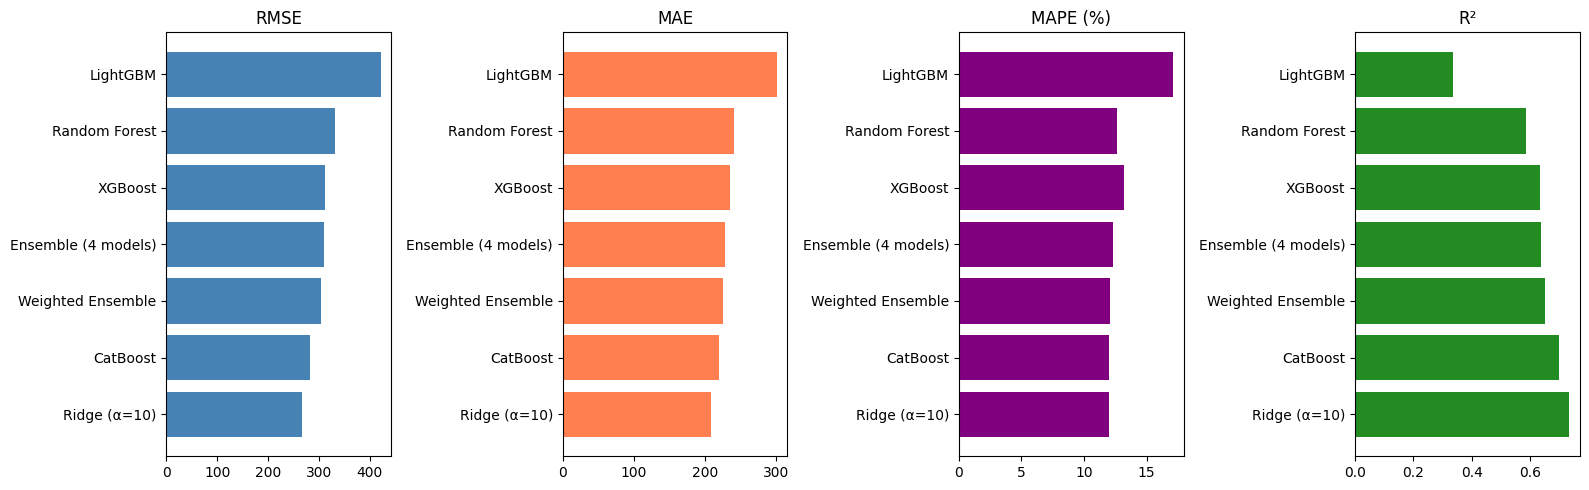

In [22]:
# Visualize
fig, axes = plt.subplots(1, 4, figsize=(16, 5))

axes[0].barh(results_df['Model'], results_df['RMSE'], color='steelblue')
axes[0].set_title('RMSE')

axes[1].barh(results_df['Model'], results_df['MAE'], color='coral')
axes[1].set_title('MAE')

axes[2].barh(results_df['Model'], results_df['MAPE'], color='purple')
axes[2].set_title('MAPE (%)')

axes[3].barh(results_df['Model'], results_df['R²'], color='forestgreen')
axes[3].set_title('R²')

plt.tight_layout()
plt.show()

## 7. Feature Importance

In [23]:
# Average importance
avg_imp = (trained_models['Random Forest'].feature_importances_ + 
           trained_models['XGBoost'].feature_importances_ + 
           trained_models['LightGBM'].feature_importances_) / 3

imp_df = pd.DataFrame({'Feature': feature_cols, 'Importance': avg_imp}).sort_values('Importance', ascending=False)
print("\nFeature Importance:")
print(imp_df.to_string(index=False))


Feature Importance:
            Feature  Importance
        weekday_cos    8.346775
           spieltag    7.476508
        weekday_sin    6.705344
               hour    4.714963
       distance_log    3.360442
opponent_attendance    3.228088
      holiday_boost    0.061052
       sunday_boost    0.045699
     is_dec_holiday    0.033370
      holiday_score    0.014687
    is_top_opponent    0.007386
         sunday_top    0.003753
       sunday_score    0.001933


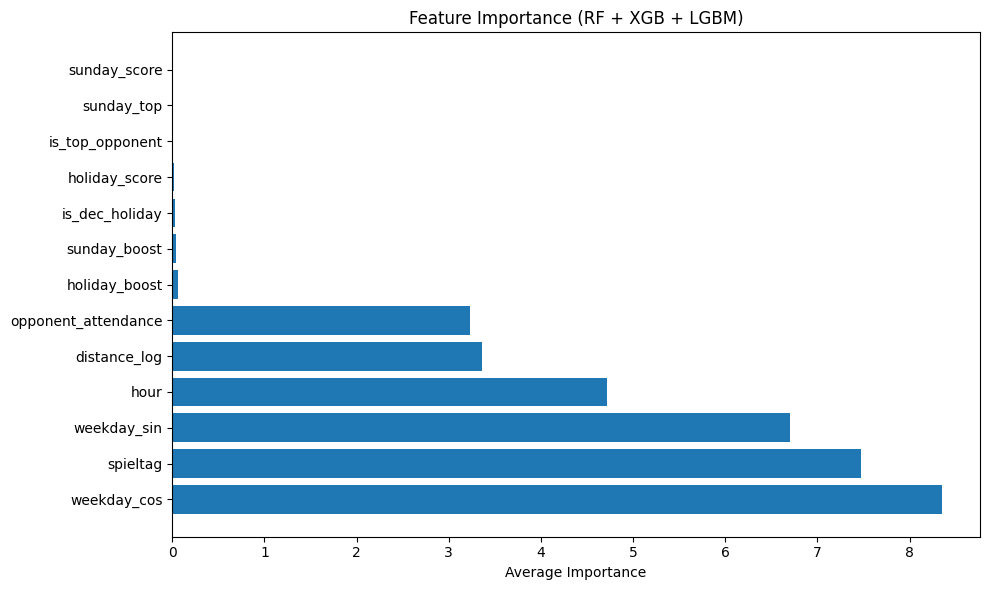

In [24]:
# Plot
plt.figure(figsize=(10, 6))
plt.barh(imp_df['Feature'], imp_df['Importance'])
plt.xlabel('Average Importance')
plt.title('Feature Importance (RF + XGB + LGBM)')
plt.tight_layout()
plt.show()

## 8. Prediction Analysis

In [25]:
# Use best model
best_name = results_df.iloc[0]['Model']
print(f"Best model: {best_name}")

if 'Ensemble' in best_name:
    y_pred_best = predictions['Weighted'] if 'Weighted' in best_name else predictions['Ensemble']
elif best_name in predictions:
    y_pred_best = predictions[best_name]
else:
    y_pred_best = predictions['Weighted']

Best model: Ridge (α=10)


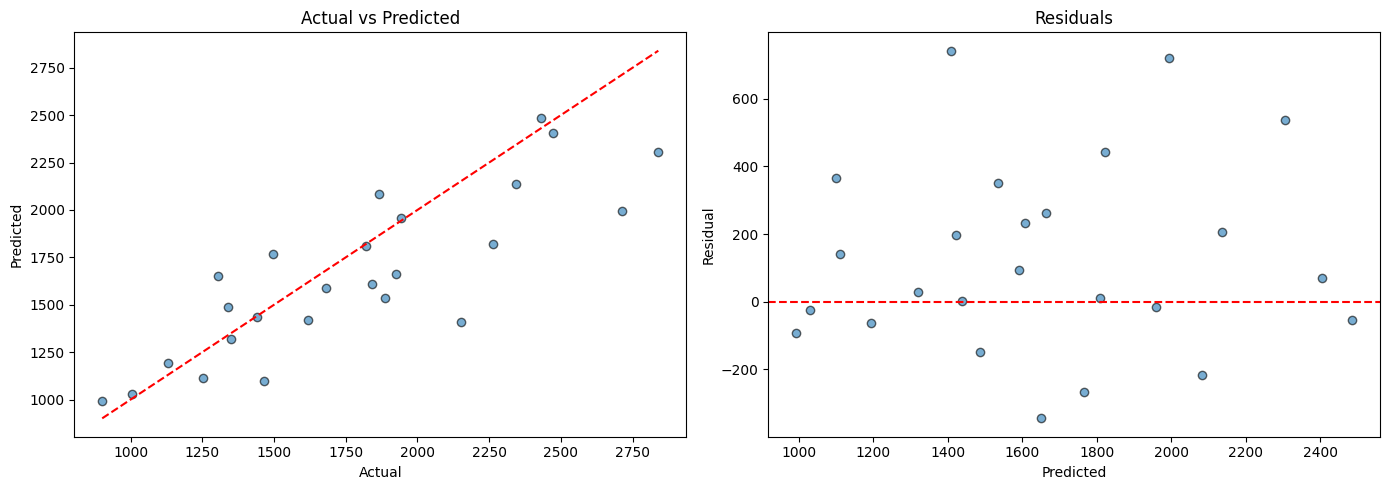

In [26]:
# Actual vs Predicted
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].scatter(y_test, y_pred_best, alpha=0.6, edgecolor='k')
lims = [min(y_test.min(), y_pred_best.min()), max(y_test.max(), y_pred_best.max())]
axes[0].plot(lims, lims, 'r--')
axes[0].set_xlabel('Actual')
axes[0].set_ylabel('Predicted')
axes[0].set_title('Actual vs Predicted')

residuals = y_test.values - y_pred_best
axes[1].scatter(y_pred_best, residuals, alpha=0.6, edgecolor='k')
axes[1].axhline(0, color='r', linestyle='--')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Residual')
axes[1].set_title('Residuals')

plt.tight_layout()
plt.show()

In [27]:
# Detailed analysis
analysis = test_data[['date', 'away_team', 'weekday', 'sunday_score', 
                       'holiday_score', 'is_top_opponent', 'ticket_count']].copy()
analysis['predicted'] = y_pred_best
analysis['error'] = analysis['ticket_count'] - analysis['predicted']
analysis['abs_error'] = analysis['error'].abs()
analysis['pct_error'] = (analysis['error'] / analysis['ticket_count'] * 100).round(1)

print("\nTop 15 Errors:")
print(analysis.sort_values('abs_error', ascending=False).head(15).to_string())


Top 15 Errors:
         date                away_team  weekday  sunday_score  holiday_score  is_top_opponent  ticket_count    predicted       error   abs_error  pct_error
58 2024-11-17  Schwenninger Wild Wings        6           2.0              0                0        2151.0  1409.061881  741.938119  741.938119       34.5
56 2024-10-20          Eisbären Berlin        6           2.0              0                1        2712.0  1992.847859  719.152141  719.152141       26.5
66 2024-12-26          Eisbären Berlin        3           0.0              4                1        2840.0  2304.347313  535.652687  535.652687       18.9
65 2024-12-22          Löwen Frankfurt        6           2.0              2                0        2265.0  1821.896015  443.103985  443.103985       19.6
54 2024-10-04  Schwenninger Wild Wings        4           0.0              1                0        1466.0  1099.898258  366.101742  366.101742       25.0
67 2025-01-05         Straubing Tigers        6 

In [28]:
# Error by game type
print("\nError Analysis:")
print("="*50)

# Sunday
sunday_mask = test_data['sunday_score'] > 0
print(f"\nSunday MAE: {np.abs(residuals[sunday_mask.values]).mean():.0f} ({sunday_mask.sum()} games)")
print(f"Other MAE: {np.abs(residuals[~sunday_mask.values]).mean():.0f} ({(~sunday_mask).sum()} games)")

# Top opponent
top_mask = test_data['is_top_opponent'] == 1
print(f"\nTop opponent MAE: {np.abs(residuals[top_mask.values]).mean():.0f} ({top_mask.sum()} games)")
print(f"Other MAE: {np.abs(residuals[~top_mask.values]).mean():.0f} ({(~top_mask).sum()} games)")

# December holiday
dec_mask = test_data['is_dec_holiday'] == 1
print(f"\nDec holiday MAE: {np.abs(residuals[dec_mask.values]).mean():.0f} ({dec_mask.sum()} games)")
print(f"Other MAE: {np.abs(residuals[~dec_mask.values]).mean():.0f} ({(~dec_mask).sum()} games)")


Error Analysis:

Sunday MAE: 291 (11 games)
Other MAE: 173 (14 games)

Top opponent MAE: 268 (8 games)
Other MAE: 205 (17 games)

Dec holiday MAE: 489 (2 games)
Other MAE: 202 (23 games)


## 9. Save Outputs

In [29]:
import os

output_dir = 'Models/baseline_model_v5'
os.makedirs(output_dir, exist_ok=True)

# Save models
for name in ['Ridge', 'Random Forest', 'XGBoost', 'LightGBM']:
    joblib.dump(trained_models[name], f'{output_dir}/{name.lower().replace(" ", "_")}_v5.joblib')
    
# CatBoost saves differently
trained_models['CatBoost'].save_model(f'{output_dir}/catboost_v5.cbm')

# Save scaler and encodings
joblib.dump(scaler, f'{output_dir}/scaler_v5.joblib')

with open(f'{output_dir}/opponent_encoding_v5.json', 'w') as f:
    json.dump(opponent_median.to_dict(), f, indent=2)

with open(f'{output_dir}/feature_cols_v5.json', 'w') as f:
    json.dump(feature_cols, f, indent=2)

results_df.to_csv(f'{output_dir}/results_v5.csv', index=False)

print("All outputs saved!")

All outputs saved!


## 10. Summary

### Version Comparison:
- **v2**: R²=0.409, MAE=330
- **v3**: R²=0.606, MAE=262  
- **v4**: R²=0.617, MAE=228
- **v5**: R²=0.734, MAE=208.11

### v5 Changes:
1. Continuous `sunday_score` instead of binary
2. `sunday_boost` = sunday × (opponent/median) ratio
3. `is_top_opponent` for big-draw teams
4. `is_dec_holiday` for high-attendance December games
5. CatBoost with native categorical opponent encoding
6. 4-model ensemble

### Next Steps:
1. Weather data integration
2. Opponent league position
3. Generate 25-26 season predictions